# Import Libraries


In [1]:
import numpy as np
import pandas as pd

from seglearn.pipe import Pype
from seglearn.transform import FeatureRep, Segment
#from seglearn.feature_functions import mean, var, std, skew, kurt
from seglearn.feature_functions import base_features, all_features

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_validate
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

import matplotlib.pyplot as plt

import random
import itertools
#%matplotlib notebook

# Importing the Data

In [2]:
FB_data_path = "./Data/Fanis_Balaskas/accel_gyro.csv"
GV_data_path = "./Data/George_Vardakas/accel_gyro.csv"
VD_data_path = ".//Data/Vagelis_Dimoulis/accel_gyro.csv"
df_FB_accel_gyro = pd.read_csv(FB_data_path)
df_GV_accel_gyro = pd.read_csv(GV_data_path)
df_VD_accel_gyro = pd.read_csv(VD_data_path)

In [3]:
# Den exw ta ms gia na spasw to shma se kathgories
datetime_format = "%Y-%m-%d %H:%M:%S.%f"
df_FB_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_FB_accel_gyro["TIMESTAMP"])#, format=datetime_format)
df_GV_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_GV_accel_gyro["TIMESTAMP"])#, format=datetime_format)
df_VD_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_VD_accel_gyro["TIMESTAMP"])

## Find when activity changes

In [4]:
# Sampling frequency of accelerometer and gyroscope (10 Hz)
sampling_frequency = df_FB_accel_gyro.loc[1, "TIMESTAMP"] - df_FB_accel_gyro.loc[0, "TIMESTAMP"]

# Finding the indexs where the samples differ more than sampling frequency
df_FB_activity_cutoff = df_FB_accel_gyro.loc[df_FB_accel_gyro["TIMESTAMP"] - df_FB_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]
df_GV_activity_cutoff = df_GV_accel_gyro.loc[df_GV_accel_gyro["TIMESTAMP"] - df_GV_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]
df_VD_activity_cutoff = df_VD_accel_gyro.loc[df_VD_accel_gyro["TIMESTAMP"] - df_VD_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]

In [5]:
df_VD_activity_cutoff

,TIMESTAMP,ACCEL_X,ACCEL_Y,ACCEL_Z,GYRO_X,GYRO_Y,GYRO_Z,ACTIVITY_ID
600,2020-12-22 17:07:21.945,3.181991,3.318464,8.655303,0.026632,0.018109,-0.019175,104
1200,2021-01-04 10:52:43.137,-1.994431,0.334001,10.059545,-0.017044,0.022370,0.013848,103
1800,2021-01-04 10:55:28.911,-4.758620,-0.949329,8.892336,0.024502,-0.028763,-0.051134,102
3000,2021-01-04 11:42:59.091,1.229460,0.306467,9.897931,0.074571,0.014914,-0.009587,107
4200,2021-01-04 12:07:21.979,-5.917449,1.804086,8.400312,-1.135606,-0.453816,-0.805364,105
4800,2021-01-04 18:50:12.842,1.034327,1.411425,9.944619,-0.009587,-0.052199,-0.047938,106


In [6]:
df_GV_activity_cutoff.index

Int64Index([  600,  1800,  4200, 10200, 13200, 18600, 23400, 24600, 28800,
            29400, 31200, 32400, 33600, 35400, 37200, 37800, 38400, 39600,
            42600, 43800, 45600, 46200, 51000],
           dtype='int64')

In [7]:
df_FB_accel_gyro.iloc[0 : 10]

,TIMESTAMP,ACCEL_X,ACCEL_Y,ACCEL_Z,GYRO_X,GYRO_Y,GYRO_Z,ACTIVITY_ID
0,2020-08-25 16:23:14.590,-1.230657,5.430215,7.670058,-1.084472,0.181100,-0.076701,107
1,2020-08-25 16:23:14.690,-1.743032,4.716721,8.117788,-1.465848,0.301478,-0.136357,107
2,2020-08-25 16:23:14.790,-2.229070,4.455745,8.960572,-1.877052,0.394159,-0.137423,107
3,2020-08-25 16:23:14.890,-2.496031,3.766193,9.097046,-1.774784,0.359005,-0.070309,107
4,2020-08-25 16:23:14.990,-2.711515,2.225478,9.026415,-2.076263,0.344090,-0.100138,107
5,2020-08-25 16:23:15.090,-2.869537,-0.124502,8.664880,-2.009150,0.584847,-0.121444,107
6,2020-08-25 16:23:15.190,-3.250227,-2.930592,9.222746,-1.166500,0.510277,0.167252,107
7,2020-08-25 16:23:15.290,-3.763800,-3.474092,7.496473,-0.559280,0.405878,0.356874,107
8,2020-08-25 16:23:15.390,-3.988861,-5.144098,7.383943,0.072440,0.340895,0.221581,107
9,2020-08-25 16:23:15.490,-4.471308,-5.087833,6.902694,0.698834,0.206667,-0.059656,107


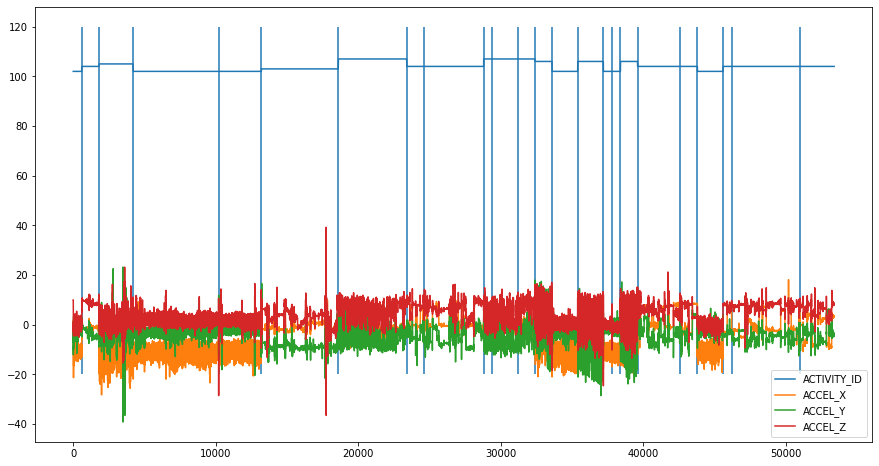

In [8]:
ax = df_GV_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
ax.vlines(df_GV_activity_cutoff.index, ymin=-20, ymax=120)

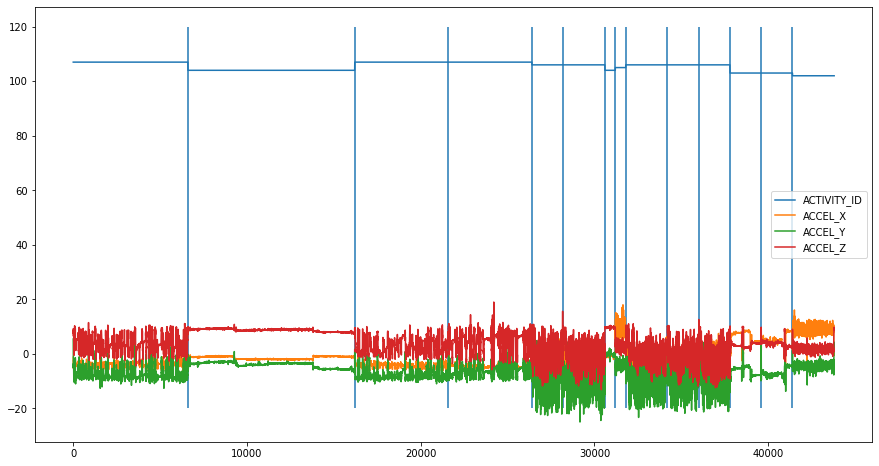

In [9]:
ax = df_FB_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
ax.vlines(df_FB_activity_cutoff.index, ymin=-20, ymax=120)

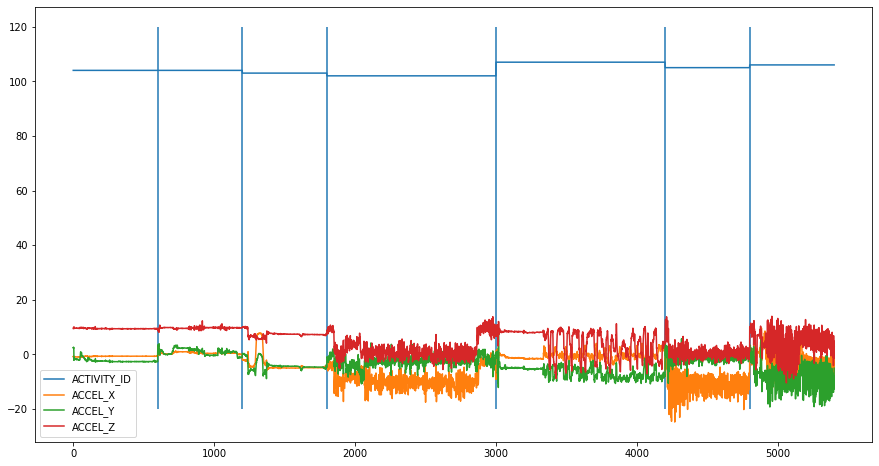

In [10]:
ax = df_VD_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
ax.vlines(df_VD_activity_cutoff.index, ymin=-20, ymax=120)

## Making one dataframe for all users

In [11]:
df_FB_accel_gyro["USER_ID"] = 0
df_GV_accel_gyro["USER_ID"] = 1
df_VD_accel_gyro["USER_ID"] = 2

In [12]:
df_accel_gyro = df_FB_accel_gyro.append(df_GV_accel_gyro)
df_accel_gyro = df_accel_gyro.append(df_VD_accel_gyro)
df_accel_gyro.reset_index(inplace=True)
del df_FB_accel_gyro, df_GV_accel_gyro, df_VD_accel_gyro

In [13]:
sampling_frequency = df_accel_gyro.loc[1, "TIMESTAMP"] - df_accel_gyro.loc[0, "TIMESTAMP"]
# Finding the indexs where the samples differ more than sampling frequency
activities = df_accel_gyro.loc[df_accel_gyro['TIMESTAMP'] - df_accel_gyro['TIMESTAMP'].shift() > sampling_frequency]
# To include the last activity to the end
activities = activities.append(df_accel_gyro.iloc[-1])

# Constracting the data exactly how the seglearn needs it
# Data must be list(np.arrays)
# list() -> single multivariate time series
# X[0].shape -> (n_samples, n_variables)
# n_samples is how many data points we have in time we have
# n_variables is how many sensors we have

# I do not include the moment where activity changes
X = list()
y = list()
groups = list()
low_index = 0

# Use this to throw some samples or not?
samples_to_throw = 10

for i, high_index in enumerate(activities.index):
    low_index += samples_to_throw
    high_index -= samples_to_throw
    data = df_accel_gyro[["ACCEL_X","ACCEL_Y", "ACCEL_Z", "GYRO_X", "GYRO_Y", "GYRO_Z"]].iloc[low_index : high_index]
    data = data.to_numpy()
    labels = df_accel_gyro["ACTIVITY_ID"].iloc[low_index]
    user_id = df_accel_gyro["USER_ID"].iloc[low_index]
    
    X.append(data)
    y.append(labels)
    groups.append(user_id)
    
    #print(low_index, mid_index, high_index)
    low_index = high_index

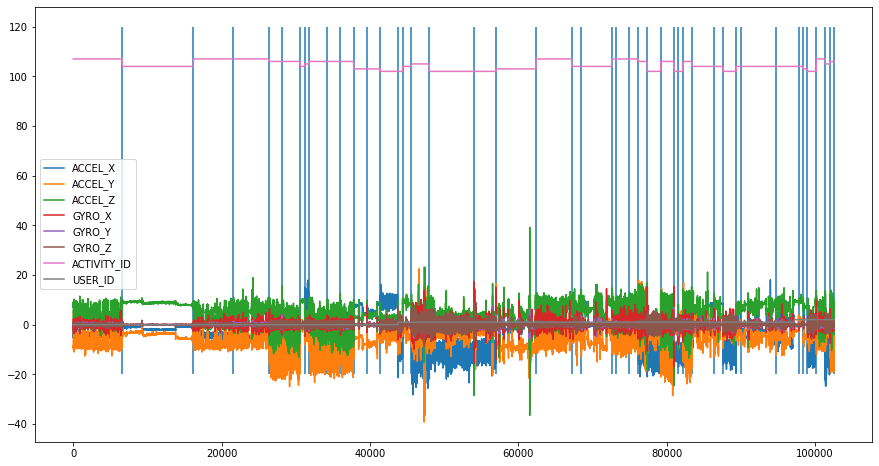

In [14]:
ax = df_accel_gyro[["ACCEL_X","ACCEL_Y", "ACCEL_Z", "GYRO_X", "GYRO_Y", "GYRO_Z", "ACTIVITY_ID", "USER_ID"]].plot(figsize=(15,8))
ax.vlines(activities.index, ymin=-20, ymax=120)

In [15]:
df_accel_gyro.iloc[-1]

index                                5399
TIMESTAMP      2021-01-04 18:51:12.742000
ACCEL_X                          0.557865
ACCEL_Y                          -5.08783
ACCEL_Z                           3.04432
GYRO_X                          -0.570999
GYRO_Y                           0.201341
GYRO_Z                           0.258866
ACTIVITY_ID                           106
USER_ID                                 2
Name: 102599, dtype: object

# Defining the features and the pipeline

In [16]:
pipeline = Pype([
    ("segment", Segment()),
    ("features", FeatureRep(features = base_features())),
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("rf", RandomForestClassifier())
], memory=None)

/home/geo/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass memory=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/geo/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


## Hyperparameter tuning

In [17]:
splitter = GroupKFold(n_splits=2)
cv = splitter.split(X, y, groups)

parameters_grid = {"segment__width": list(range(150, 350, 50)),
                   "segment__overlap": np.arange(0.0, 0.3, 0.1).tolist(),
                   "pca__n_components" : [46, 56, 66],
                   "rf__n_estimators": range(20, 50, 5)
                  }

# scoring does not work for some reason
# it maybe always say the big category for each fragment
# scoring="accuracy", maybe because random forest has out of bag error 
grid_search = GridSearchCV(pipeline, parameters_grid, cv=cv, n_jobs=-1)
grid_search.fit(X, y)

print(grid_search.best_score_)
print(grid_search.best_estimator_)

/home/geo/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass memory=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/geo/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


0.624806443928295
Pype(steps=[('segment', Segment(overlap=0.1, width=150)),
            ('features',
             FeatureRep(features={'abs_energy': <function abs_energy at 0x7f65d8226e50>,
                                  'kurt': <function kurt at 0x7f65d81ad310>,
                                  'max': <function maximum at 0x7f65d81ad1f0>,
                                  'mean': <function mean at 0x7f65d8226af0>,
                                  'median': <function median at 0x7f65d8226b80>,
                                  'min': <function minimum at 0x7f65d81ad160>,
                                  'mnx': <function mean_crossings at 0x7f65d81ad550>,
                                  'mse': <function mse at 0x7f65d81ad4c0>,
                                  'skew': <function skew at 0x7f65d81ad280>,
                                  'std': <function std at 0x7f65d8226ee0>,
                                  'var': <function var at 0x7f65d8226f70>})),
            ('scaler', Sta

/home/geo/.local/lib/python3.8/site-packages/seglearn/transform.py:237: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Xt = np.array([sliding_tensor(Xt[i], self.width, self._step, self.order)


## Cross validation on the best model

In [18]:
best_estimator = grid_search.best_estimator_

cv = splitter.split(X, y, groups)

results = cross_validate(best_estimator, X, y, cv=cv, n_jobs=-1)
results

/home/geo/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass memory=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/geo/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


{'fit_time': array([0.12441683, 0.12897301]),
 'score_time': array([0.05375624, 0.06133676]),
 'test_score': array([0.53626943, 0.59770115])}

In [21]:
def plot_confusion_matrix(cm, classes, fold, normalize=True, cmap=plt.cm.Blues):
    title = "Confusion matrix " + str(fold)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize = (15, 8))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.title(title, fontsize=15)
    plt.ylabel("True label", fontsize=15)
    plt.xlabel("Predicted label", fontsize=15)
    plt.tight_layout()
    #plt.savefig(graphs_path + title, facecolor = "#E0E0E0")
    plt.show()

## Creating the confusion matrix for each fold

/home/geo/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass memory=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/geo/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/geo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/geo/.local/lib/python3.8/site-packages/seg

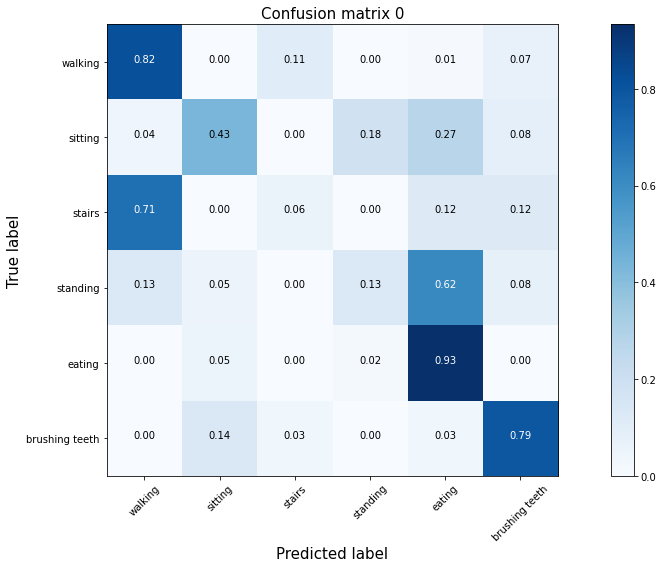

0.5932642487046632
[[85  0 11  0  1  7]
 [ 5 59  0 25 37 11]
 [12  0  1  0  2  2]
 [ 5  2  0  5 24  3]
 [ 0  3  0  1 56  0]
 [ 0  4  1  0  1 23]]


/home/geo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/geo/.local/lib/python3.8/site-packages/seglearn/transform.py:237: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Xt = np.array([sliding_tensor(Xt[i], self.width, self._step, self.order)
/home/geo/.local/lib/python3.8/site-packages/seglearn/transform.py:237: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarr

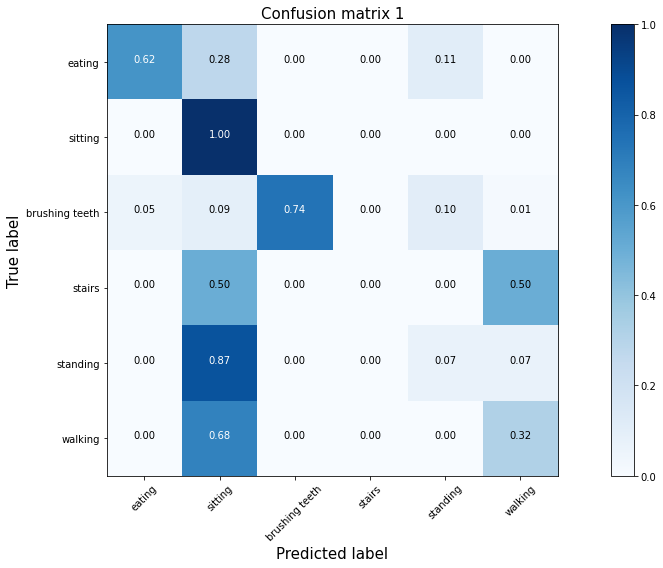

0.646551724137931
[[80 36  0  0 14  0]
 [ 0 78  0  0  0  0]
 [ 4  7 57  0  8  1]
 [ 0  4  0  0  0  4]
 [ 0 26  0  0  2  2]
 [ 0 17  0  0  0  8]]


In [22]:
# This pipe is only for data transformations
transform_pipe = Pype([
    ("segment", best_estimator.named_steps["segment"]),
    ("features", best_estimator.named_steps["features"]),
    ("scaler", best_estimator.named_steps["scaler"]),
    ("pca", best_estimator.named_steps["pca"]),
], memory=None)

df_activities = pd.read_csv("./Data/HomoreDataFromVariousActivities/activities.csv")

cv = splitter.split(X, y, groups)
for fold, split in enumerate(cv):
    training_set, test_set = split
    
    # Spliting the to training and testing set
    x_train, x_test = np.asarray(X)[training_set], np.asarray(X)[test_set]
    y_train, y_test = np.asarray(y)[training_set], np.asarray(y)[test_set]
    
    visited = dict()
    labels = list()
    for yi_label in y_test:
        if yi_label not in visited:
            visited[yi_label] = True
            labels.append(yi_label)
    
    # Transforming the test data to fit the model predictions
    _, y_test_trans = transform_pipe.fit_transform(x_test, y_test)
    
    # Fiting the model
    best_estimator.fit(x_train, y_train)
    
    # Predicting with trained model
    y_pred = best_estimator.predict(x_test)
    
    # Printing accuracy score and confusion matrix
    confusion_mat = confusion_matrix(y_test_trans, y_pred, labels=labels)
    clf_accuracy = accuracy_score(y_test_trans, y_pred)
    
    # Select the right labels and order them correcly
    labels_names = df_activities.loc[df_activities["ACTIVITY_ID"].isin(labels)]
    labels_names = labels_names.iloc[pd.Categorical(labels_names["ACTIVITY_ID"], categories = labels, ordered=True).argsort()]
    labels_names = labels_names["NAME"].to_list()
    plot_confusion_matrix(confusion_mat, labels_names, fold, normalize=True)
    
    print(clf_accuracy)
    print(confusion_mat)